# Segmentation networks

We will use LinkNet, UNet, FCN32 and FCN8 (realized as TFModel) to segmenation of $64 \times 64$ images with MNIST $28 \times 28$ at random place (uniformly sampled) with noise generated on the base of MNIST fragments. Each fragment is randomly cutted from random image from the same batch and is rotated by an angle $ \sim U(0,360^{\circ})$. Coordinates of top-left corner are sampled from uniform $U(0, 64-s)$ or normal $N\left(\frac{64-s}{2}, \left(\frac{64-s}{4}\right)^2\right)$ distribution where $s$ is equal to width (height) of rotated image.

In [1]:
import sys
from time import time
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

sys.path.append('..')

from dataset import Pipeline, DatasetIndex, Dataset, B, V

from dataset.opensets import MNIST
from dataset.models.tf import UNet, LinkNet, FCN32, FCN8
from noised_mnist import NoisedMnist                                          # Batch subclass with loading and noise actions
from plot_functions import plot_noised_image, plot_examples_highlighted       # plot functions to demonstrate result 

Fix constants to generate noised images and train LinkNet:

In [2]:
IMAGE_SIZE = 64     # image size
MNIST_SIZE = 65000  # MNIST database size
BATCH_SIZE = 32     # batch size for NN training
MAX_ITER = 200      # number of iterations for NN training
DATA_FORMAT = 'channels_first'

Define noise parameters:

In [3]:
level = 1           # the highest level of noise; [0, 1]
n_fragments = 80    # number of noise fragments per image  
size = 4            # size of noise fragment; 1, ..., 27
distr = 'uniform'   # distribution of fragments of image; 'uniform' or 'normal'

Create DatasetIndex and Dataset to use pipelines:

In [4]:
mnistset = MNIST(batch_class=NoisedMnist)

ExtractingExtractingExtractingExtracting    C:\Users\kozhevin\AppData\Local\Temp\train-images-idx3-ubyte.gzC:\Users\kozhevin\AppData\Local\Temp\train-labels-idx1-ubyte.gzC:\Users\kozhevin\AppData\Local\Temp\t10k-images-idx3-ubyte.gzC:\Users\kozhevin\AppData\Local\Temp\t10k-labels-idx1-ubyte.gz





Сreate Pipeline template for image loading and transformation. The first parameter of create_noise is the type of noise: 'mnist_noise' - MNIST-based noise, 'random_noise' - uniform random noise.

Create config for placeholders of the model. Key in dict is name of the created placeholder.
* '<b>shape</b>' - shape of the input of model
* '<b>type</b>' - tf.dtype of input
* '<b>data_format</b>' - one of channels_last (default) or channels_first
* '<b>name</b>' - name of the placeholder after reshaping 

In [5]:
shape = (1, IMAGE_SIZE, IMAGE_SIZE) if DATA_FORMAT == 'channels_first' else (IMAGE_SIZE, IMAGE_SIZE, 1)

placeholders_config = {
                       'images': {'shape': shape,
                                  'type': 'float32',
                                  'data_format': DATA_FORMAT,
                                  'name': 'reshaped_images'},
                
                       'masks': {'shape': (IMAGE_SIZE, IMAGE_SIZE),
                                 'type': 'int32',
                                 'transform': 'ohe',
                                 'data_format': DATA_FORMAT,
                                 'classes': 2,
                                 'name': 'targets'}
                       }

Create model_config.
* '<b>inputs</b>' - dict of placeholders configs
* '<b>input_block/inputs</b>' - name of tensor which is an input of input block
* '<b>batch_norm</b>' - enable batch normalization
* '<b>n_blocks</b>' - number of encoding/decoding blocks (4 by default)
* '<b>n_filters</b>' - number of filters after the first convolution (64 by default)
* '<b>output</b>' - dict of operations to add into graph
* '<b>loss</b>' - loss function
* '<b>optimizer</b>' - loss function

In [6]:
def loss(labels, logits):
    labels = tf.transpose(labels, [0, 2, 3, 1])
    logits = tf.transpose(logits, [0, 2, 3, 1])
    res = tf.losses.softmax_cross_entropy(labels, logits)
    return res

In [7]:
model_config = {'inputs': placeholders_config,
                'input_block/inputs': 'images',
                'batch_norm': {'momentum': 0.1},
                'output': dict(ops=['proba']),
                'loss': 'ce' if DATA_FORMAT == 'channels_last' else loss,
                'optimizer': 'Adam'}

Create feed dicts. The key is name of the tensor in tf graph, value is batch component.

In [8]:
train_feed_dict = {'images': B('images'),
                   'masks': B('masks')}        

test_feed_dict = {'images': B('images'),
                  'masks': B('masks')}

In [9]:
def binary_iou(masks, predictions, data_format='channels_last'):
    ind = np.index_exp[:, :, :, 1] if data_format == 'channels_last' else np.index_exp[:, 1, :, :]
    predictions = predictions[ind]
    intersection = np.sum(np.logical_and((predictions > 0.5), masks))
    union = np.sum(np.logical_or((predictions > 0.5), masks))
    return intersection / union  

def demonstrate_model(model, data_format='channels_last'):
    print('Create pipelines...')

    load_template = (Pipeline()
                 .random_location(IMAGE_SIZE)      # put MNIST at random location
                 .make_masks()                     # create mask for MNIST image location
                 .create_noise('mnist_noise', level, n_fragments, size, distr)
                 .add_noise())
    if data_format == 'channels_first':
        load_template = load_template.swap_axis()
    
    ppl_train = ((load_template << mnistset.train)                         # load data from file
            .init_model('static', model, 'NN', config=model_config)
            .init_variable('loss', init_on_each_run=list)
            .train_model('NN',
                         fetches='loss',
                         feed_dict=train_feed_dict,
                         save_to=V('loss'), mode='a'))

    print('Start training...')
    start = time()
    for i in range(MAX_ITER):
        ppl_train.next_batch(BATCH_SIZE, n_epochs=None, shuffle=True)
        #print(ppl_train.get_variable('loss')[-1])
    stop = time()
    print("Train time: {:05.3f} min".format((stop-start)/60))

    ppl_test = ((load_template << mnistset.test)
             .import_model('NN', ppl_train)
             .init_variable('predictions', init_on_each_run=list)
             .predict_model('NN',                                      
                           fetches='predicted_proba',
                           feed_dict=test_feed_dict,
                           save_to=V('predictions'),
                           mode='a'))

    batch = ppl_test.next_batch(100, n_epochs=None)
    images = batch.data.images
    masks = batch.data.masks
    noise = batch.data.noise
    predictions = ppl_test.get_variable('predictions')[-1]

    print('Test IoU: {0:.3f}'.format(binary_iou(masks, predictions, data_format)))

    plot_examples_highlighted(ppl_test, 5, model.__name__, data_format=data_format)

Create pipelines...
Start training...
Train time: 1.814 min
Test IoU: 0.527


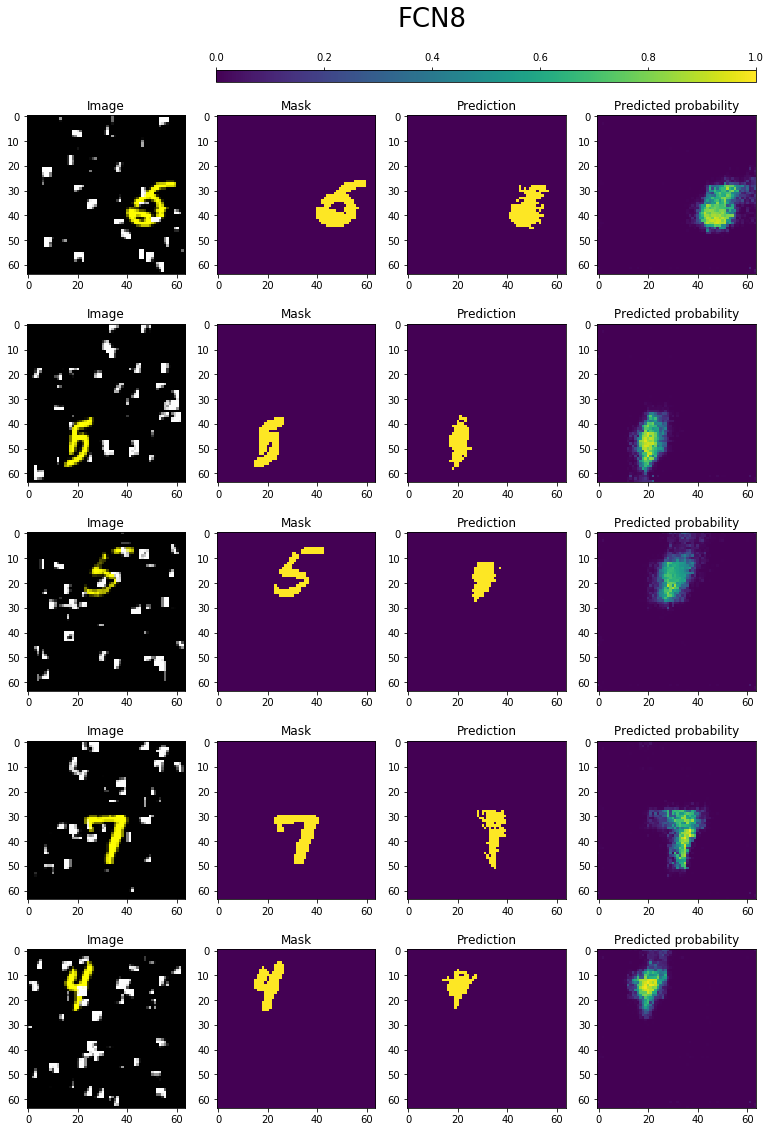

In [10]:
demonstrate_model(FCN8, DATA_FORMAT)

Create pipelines...
Start training...
Train time: 1.804 min
Test IoU: 0.406


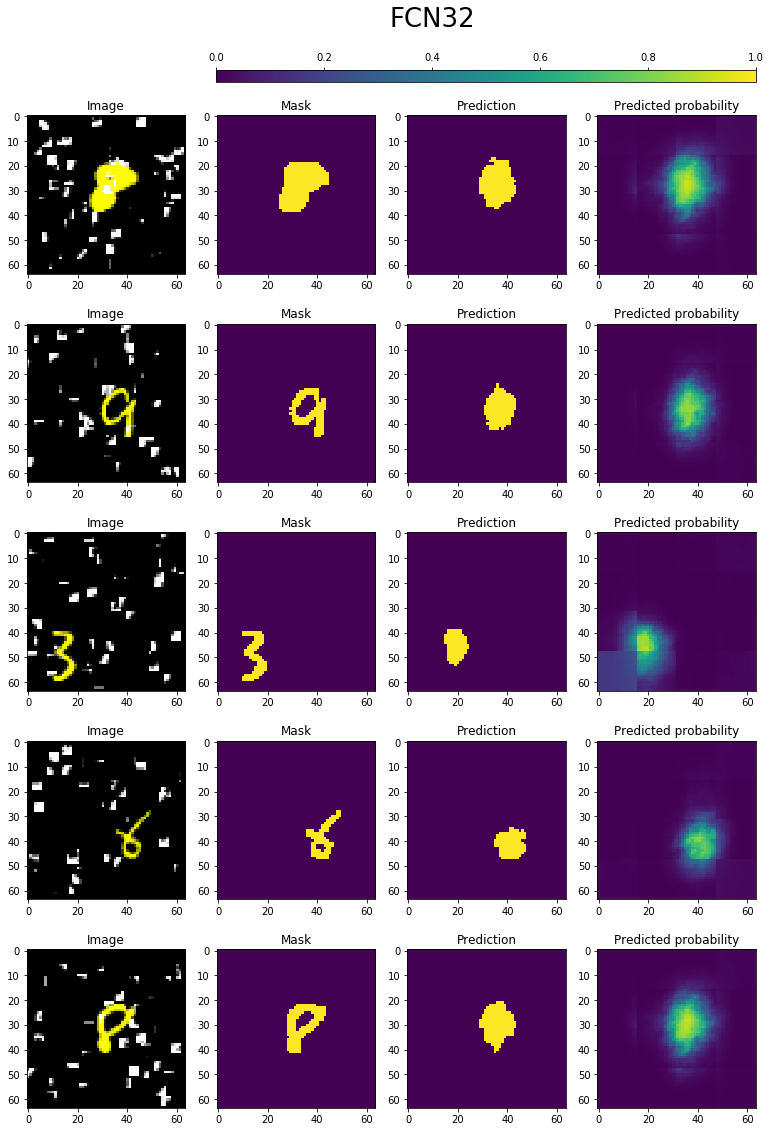

In [11]:
demonstrate_model(FCN32, DATA_FORMAT)

Create pipelines...
Start training...
Train time: 1.607 min
Test IoU: 0.520


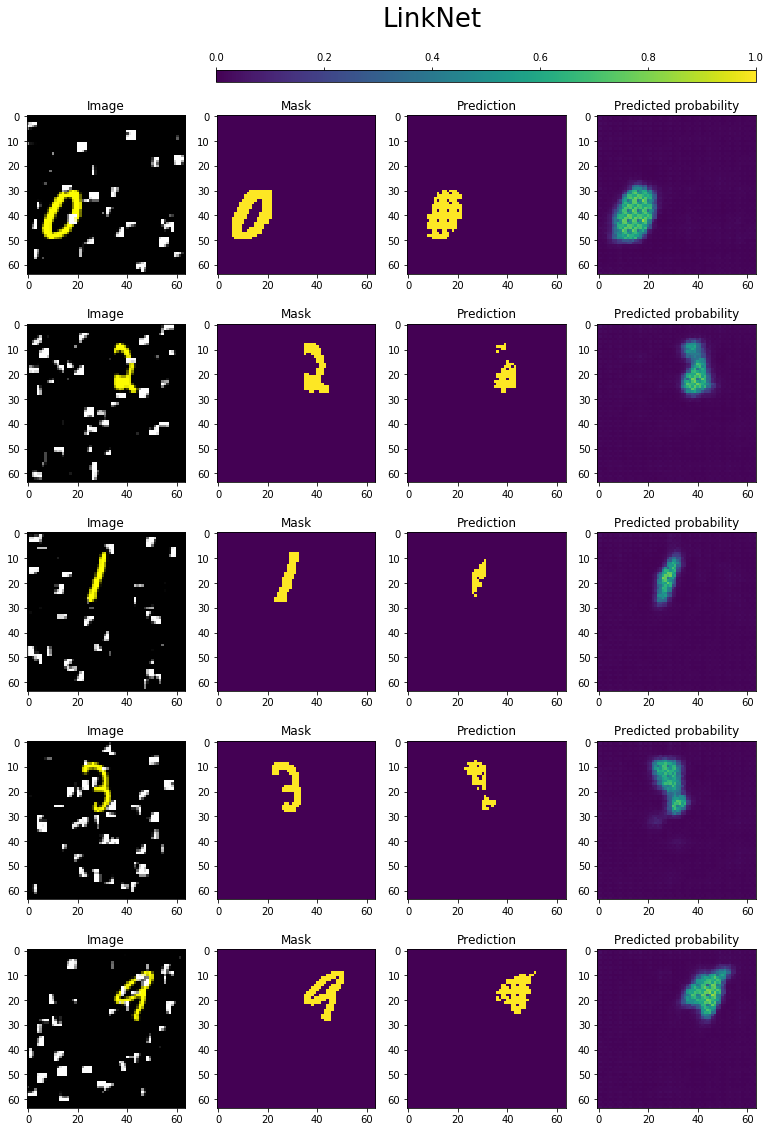

In [12]:
demonstrate_model(LinkNet, DATA_FORMAT)

Create pipelines...
Start training...
Train time: 2.775 min
Test IoU: 0.896


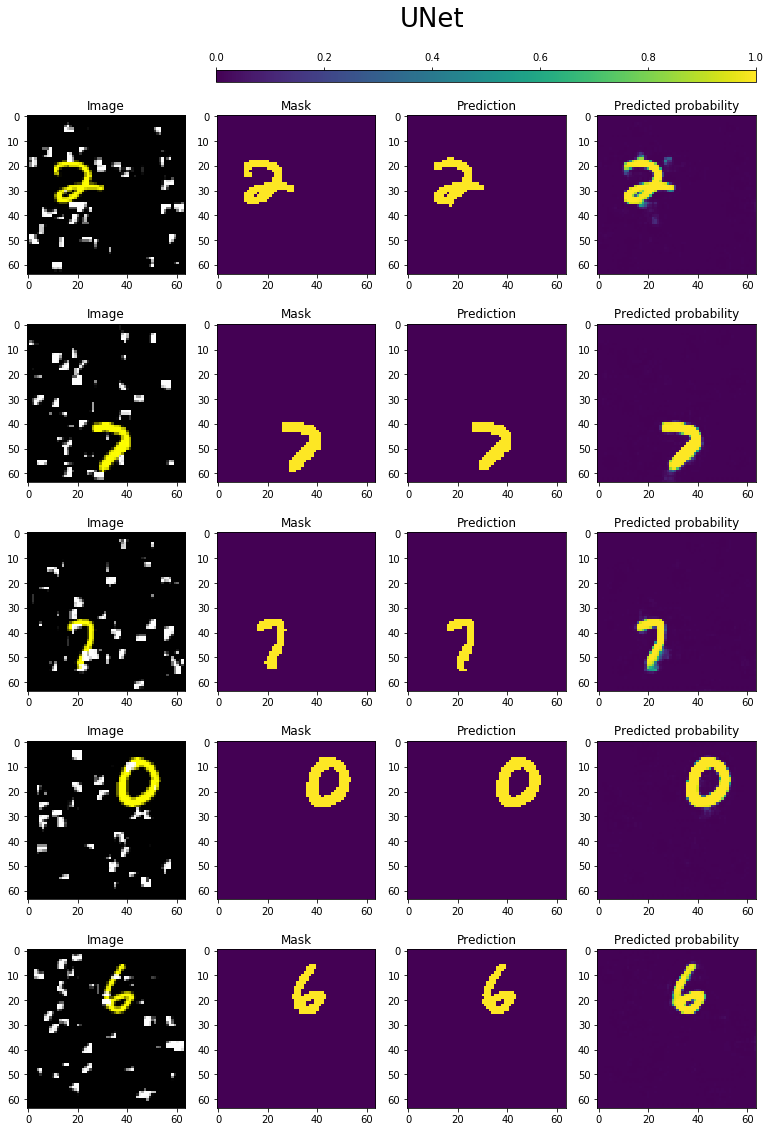

In [13]:
demonstrate_model(UNet, DATA_FORMAT)